This notebook shows how to use `optimex` with a case study of optimizing the transition of an energy system. The case study is highly simplified, not meant to reflect the complexity of energy system but to demonstrate how to use `optimex`. Its structure is based on the demonstration notebooks of [timex](https://github.com/brightway-lca/bw_timex/tree/main/notebooks)

In [1]:
import bw2data as bd
import bw2calc as bc

bd.projects.set_current("optimex_310")
bd.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei3.10-SSP2-RCP19-2020
	ei3.10-SSP2-RCP19-2030
	ei3.10-SSP2-RCP19-2040
	ei3.10-SSP2-RCP19-2050
	foreground

## Case study setup

The `optimex` package itself does not provide any data - specifying prospective and dynamic information is up to the user. In this example, we use data from ecoinvent v3.10, and create a set of prospective databases with [premise](https://github.com/polca/premise). We applied projections for the future electricity sectors using the SSP2-RCP19 pathway from the IAM IMAGE. We selected this pathway to simply demonstrate some future development in this case study, and many other models and pathways are available. In the premise documentation you can find instructions for the creation of prospective background databases.

In [2]:
ecoinvent_vs = "3.10"

db_2020 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2020")
db_2030 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2030")
db_2040 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2040")
db_2050 = bd.Database(f"ei{ecoinvent_vs}-SSP2-RCP19-2050")

## Case study setup

In this case study, we aim to optimize the transition of a distributed energy system with three available technologies generating electricity:
- wind turbine
- lignite power plant
- natural gas power plant

We model a simplified life cycle inventory for our technologies based on the following data

### General Data

| Power Plant Type              | Full Load Hours (per year) | Lifetime (years) | Typical Plant Size |
|-------------------------------|----------------------------|------------------|--------------------|
| Wind                          | 2,000 - 4,000 hours        | 20 - 25 years    | 2 MW               |
| Lignite (Brown Coal)          | 5,000 - 7,000 hours        | 30 - 50 years    | 500 MW             |
| Natural Gas (Combined Cycle)  | 3,000 - 6,000 hours        | 25 - 40 years    | 500 MW             |

First, create a new foreground database:

In [3]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.write({})
foreground.register()

The available technologies for our transition have to be in the foreground system. Therefore we copy them from the bg in the fg

In [4]:
import uuid

original_bg_activities_el = {
    "wind": db_2020.get(name="electricity production, wind, >3MW turbine, onshore", location="DE"),
    "lignite": db_2020.get(name="electricity production, lignite", location="DE"),
    # "natural gas": db_2020.get(name="electricity production, natural gas, combined cycle power plant", location="DE"),
    "photovoltaic": db_2020.get(name="electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted", location="DE"),
    "co-generation, natural gas": db_2020.get(name="heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical", location="DE", unit="kilowatt hour"),
    "co-generation, wood chips": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="kilowatt hour"),
    "co-generation with fuel cell": db_2020.get(name="electricity, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="kilowatt hour"), 
    # el allocation: 0.876663232584123, LHV [kWh/kg]: 33.3333333333333
}

original_bg_activities_heat = {
    "municipal waste": db_2020.get(name="heat, from municipal waste incineration to generic market for heat district or industrial, other than natural gas", location="DE", unit="megajoule"),
    "co-generation, natural gas": db_2020.get(name="heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical", location="DE", unit="megajoule"),
    "co-generation, wood chips": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="megajoule"),
    "co-generation with fuel cell": db_2020.get(name="heat, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="megajoule"), 
    # heat allocation: 0.123336767415877, LHV [MJ/kg]: 120
}

for key, act in original_bg_activities_el.items():
    fg_act = act.copy(code=str(uuid.uuid4()), database=foreground.name)
    fg_act["name"] = f"electricity production, {key}, time-explicit"
    fg_act["functional flow"] = "electricity"
    fg_act.save()

for key, act in original_bg_activities_heat.items():
    fg_act = act.copy(code=str(uuid.uuid4()), database=foreground.name)
    fg_act["name"] = f"heat production, {key}, time-explicit"
    fg_act["functional flow"] = "heat"
    fg_act.save()

[act for act in foreground]


['heat production, co-generation, natural gas, time-explicit' (megajoule, DE, None),
 'electricity production, lignite, time-explicit' (kilowatt hour, DE, None),
 'electricity production, photovoltaic, time-explicit' (kilowatt hour, DE, None),
 'electricity production, wind, time-explicit' (kilowatt hour, DE, None),
 'electricity production, co-generation, natural gas, time-explicit' (kilowatt hour, DE, None),
 'heat production, co-generation, wood chips, time-explicit' (megajoule, DE, None),
 'heat production, municipal waste, time-explicit' (megajoule, DE, None),
 'heat production, co-generation with fuel cell, time-explicit' (megajoule, RER, None),
 'electricity production, co-generation with fuel cell, time-explicit' (kilowatt hour, CH, None),
 'electricity production, co-generation, wood chips, time-explicit' (kilowatt hour, DE, None)]

In [5]:
# act = original_bg_activities_heat["co-generation, natural gas"]
# act_dict = act.as_dict()
# print(act_dict["comment"])
# [exc for exc in act.exchanges() if exc["type"]=="technosphere"] # he 6.259077406254446e-07

| Power Plant Type                          | Expected Lifetime (Years) |
|-------------------------------------------|---------------------------|
| Wind Turbine                              | 20–25                    |
| Lignite Conventional Power Plant          | 40–50                    |
| Natural Gas Combined Cycle Power Plant    | 25–40                    |
| CHP with Wood Chips                       | 20–30                    |
| Municipal Waste Incineration Power Plant  | 25–35                    |
| Fuel Cell (PEM)                           | 5–15                     |
| Photovoltaic                              | 25–30                    |


### Temporal distribution

Now that the production system is modelled, we can add temporal distributions at the exchange level. 

In [6]:
import numpy as np
import bw_temporalis as bwt


lifetime_dict = {
    "wind": 22,
    "lignite": 45,
    "photovoltaic": 27,
    "co-generation, natural gas": 36,
    "co-generation, wood chips": 25,
    "co-generation with fuel cell": 10,
    "municipal waste": 30,   
}

construction_time_dict = {
    "wind": 2,
    "lignite": 3,
    "photovoltaic": 1,
    "co-generation, natural gas": 3,
    "co-generation, wood chips": 2,
    "co-generation with fuel cell": 1,
    "municipal waste": 2,   
}

In [7]:
#TODO: check for potential improvements for mapping quality based on metadata

def set_temporal_distribution(activity: bd.backends.proxies.Activity, construction_time, lifetime):
    construction_keywords = ["construct", "build", "install", "erect", "assemble", "fabricate", "manufacture"]
    operation_keywords = ["use", "operation", "maintenance", "yearly" , "annual", "supply"]
    end_of_life_keywords = ["end of life", "decommission", "disposal", "recycling"]
    
    td_construction = bwt.easy_timedelta_distribution(
        start=0,
        end=construction_time,
        resolution="Y",
        steps=(construction_time + 1),
        kind="uniform" if construction_time < 2 else "triangular",
    )

    td_use_phase = bwt.easy_timedelta_distribution(
        start=construction_time,
        end=construction_time+lifetime,
        resolution="Y",
        steps=(lifetime + 1),
        kind="uniform",
    )

    td_decommissioning = bwt.TemporalDistribution(
        date=np.array([construction_time + lifetime + 1], dtype="timedelta64[Y]"), amount=np.array([1])
    )

    for exc in activity.exchanges():
        exc_name = exc.input["name"].lower()
        exc_comment = exc.input.get("comment", "").lower()
        phase = None
        
        # Determine the lifecycle phase based on the exchange name
        # if any(keyword in exc_name or exc_comment for keyword in construction_keywords):
        #     phase = "construction"
        # elif any(keyword in exc_name or exc_comment for keyword in end_of_life_keywords):
        #     phase = "decommissioning"
        # elif any(keyword in exc_name or exc_comment for keyword in operation_keywords):
        #     phase = "use"

        if phase == None or exc["type"] == "production": # default to operation
            phase = "use"

        hardcoded_construction_exchanges = [
            "market for dust collector, electrostatic precipitator, for industrial use",
            "market for furnace, wood chips, with silo, 5000kW",
            "market for heat and power co-generation unit, organic Rankine cycle, 1000kW electrical",
            "fuel cell system assembly, 1 kWe, proton exchange membrane (PEM)",
            "market for photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof",
            "lignite power plant construction",
            "market for wind turbine network connection, 4.5MW, onshore",
            "market for wind turbine, 4.5MW, onshore",
            "market for transport, freight, lorry 7.5-16 metric ton, EURO3",
            "gas power plant construction, combined cycle, 400MW electrical"
        ]

        if exc["name"] in hardcoded_construction_exchanges:
            phase = "construction"

        if phase == "construction":
            exc["temporal_distribution"] = td_construction
        elif phase == "use":
            exc["temporal_distribution"] = td_use_phase
        elif phase == "decommissioning":
            exc["temporal_distribution"] = td_decommissioning

        # print(phase, exc["name"])
        exc.save()
    return activity

for act in foreground:
    key = next((k for k in lifetime_dict if k in act['name'].lower()), None)
    if key:
        construction_time = construction_time_dict[key]
        lifetime = lifetime_dict[key]
    set_temporal_distribution(act, construction_time, lifetime)
    act.save()

We have now defined the available energy technologies, including wind turbines, lignite and natural gas power plants, CHP systems, waste incineration, fuel cells, and photovoltaic systems. The next step is to define the demand curves for electricity (measured in kWh) and heat (measured in MJ).

In [8]:
import numpy as np
demand_el = np.asarray([0, 0, 0, 0, 500, 500, 520, 540, 560, 580, 600, 800, 800, 816, 833, 850, 866, 883, 900, 900, 890, 880, 880, 915, 950, 950, 962, 975, 987, 1000])*1e3
demand_heat = np.asarray([0, 0, 0, 0, 0, 0, 160, 320, 480, 640, 800, 2000, 2000, 2083, 2166, 2250, 2333, 2416, 2500, 2500, 2400, 2300, 2300, 2400, 2500, 2500, 2525, 2550, 2575, 2600])*1e3
years = np.arange(2020, 2050)

td_demand_el = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_el
)
td_demand_heat = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_heat
)

demand_input = {
    "electricity": td_demand_el,
    "heat": td_demand_heat,
}

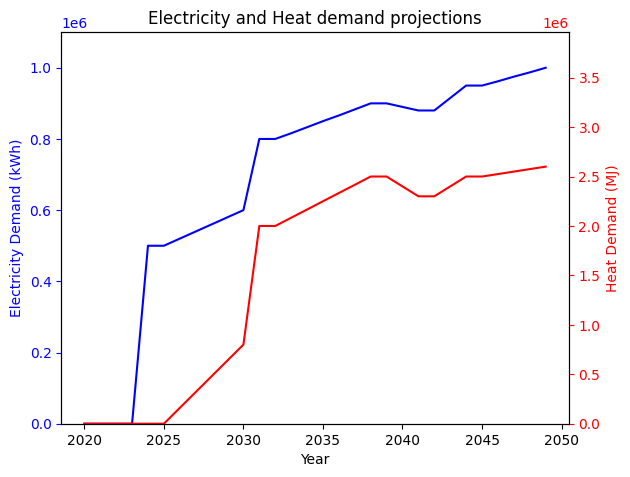

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot electricity demand on the left y-axis
ax1.plot(years, demand_el, 'b-', label='Electricity Demand (kWh)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Electricity Demand (kWh)', color='b')
ax1.set_ylim(0, 1.1*max(demand_el))
ax1.tick_params('y', colors='b')

# Create a second y-axis for heat demand
ax2 = ax1.twinx()
ax2.plot(years, demand_heat, 'r-', label='Heat Demand (MJ)')
ax2.set_ylabel('Heat Demand (MJ)', color='r')
ax2.set_ylim(0, 1.1*max(demand_el)*3.6) # convert MJ to kWh
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.title('Electricity and Heat demand projections')
plt.show()

### Transition pathway optimization

We need to select an impact assessment method to minimize:

In [10]:
# for m in bd.methods:
#     bd.Method(m).process()

In [11]:
method = ('ecoinvent-3.10', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')

`optimex` also needs to know the representative time of the databases:

In [12]:
from datetime import datetime

database_date_dict = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    # db_2030.name: datetime.strptime("2030", "%Y"),
    # db_2040.name: datetime.strptime("2040", "%Y"),
    # db_2050.name: datetime.strptime("2050", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}

In [13]:
import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s  - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

In [14]:
from optimex import optimex

start_date = datetime.strptime("2020", "%Y")
timehorizon = 80

opt = optimex.Optimex(
    demand = demand_input,
    start_date=start_date,
    method=method,
    database_date_dict = database_date_dict,
    timehorizon=timehorizon,
)

test


In [15]:
technosphere_tensor, biosphere_tensor, production_tensor = opt.construct_foreground_tensors()

In [16]:
demand_matrix = opt.parse_demand()

In [17]:
import pickle

def save_dict_to_file(tensor, filename):
    with open(filename, 'wb') as f:
        pickle.dump(tensor, f)

def load_dict_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
   
inventory_tensor = load_dict_from_file('inventory_tensor.pkl')
inventory_tensor = {
    k: v for k, v in inventory_tensor.items() if k[0] == db_2020.name
}

opt.load_inventory_tensors(inventory_tensor)

# inventory_tensor = opt.sequential_inventory_tensor_calculation(cutoff=1e4)
# save_dict_to_file(inventory_tensor, 'inventory_tensor.pkl')

In [18]:
mapping_matrix = opt.construct_mapping_matrix()

In [19]:
characterization_matrix = opt.construct_characterization_matrix(dynamic=False, metric="GWP")

In [21]:
from optimex.converter import Converter

converter = Converter(opt)

In [22]:
process_limit_max = {}

for process, name in opt.processes.items():
    if name == "electricity production, wind, time-explicit":
        for t in opt.system_time:
            if t % 2 == 0:
                process_limit_max[(process, t)] = 100000
            else:
                process_limit_max[(process, t)] = 0
    else:
        continue

cumulative_process_limit_max = {}
for process, name in opt.processes.items():
    if name == "electricity production, photovoltaic, time-explicit":
        cumulative_process_limit_max[process] = 1000000
    elif name == "heat production, municipal waste, time-explicit":
        cumulative_process_limit_max[process] = 2000000

# additional constraint coupling capacity of heat and electricity co-generation
name_process_dict = {v: k for k, v in opt.processes.items()}
process_coupling = {
    (name_process_dict["heat production, co-generation, natural gas, time-explicit"],
      name_process_dict["electricity production, co-generation, natural gas, time-explicit"]): 2.9,
    (name_process_dict["heat production, co-generation, wood chips, time-explicit"],
        name_process_dict["electricity production, co-generation, wood chips, time-explicit"]): 10.8,
    (name_process_dict["heat production, co-generation with fuel cell, time-explicit"],
        name_process_dict["electricity production, co-generation with fuel cell, time-explicit"]): 3.6,
}

In [23]:
unconstrained_inputs = converter.combine_and_check()
constrained_inputs = converter.combine_and_check(**{
    "process_limits_max": process_limit_max,
    "cumulative_process_limits_max": cumulative_process_limit_max,
    "process_coupling": process_coupling,
})

In [24]:
converter.pickle_model_inputs("static_opt_inputs.pkl")